# GAN that generates faces

The objective of this Jupyter Notebook is the creation of a GAN (Generative Adversarial Network) that has the capability of creating faces, based on the "celeb" dataset.

## Requirements

* Python 3
* Tensorflow
* GPU (so the training process can be faster)
* Google Drive Account
* Celeb dataset

🚨 Have activated **Hardware Acceleration** with GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-58d12975-062b-8efe-5689-ffc3c14ff334)


## Step 1. Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive

Mounted at /gdrive
/gdrive


## Step 2. Install needed libraries

In [3]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install tensorflow==2.7

import tensorflow as tf

print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-p5rkol_q
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-p5rkol_q
  Resolved https://github.com/tensorflow/docs to commit bfb6df29b92c5f85a1246d69c5097bdbb5105b29
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=182618 sha256=bdfb25b36c952d697af17b47d8765d901c5d7e7b23f16e495ed9762f2e6c77a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9t4_x7r/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 3. Importing libraries

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import glob
import imageio

## Step 4. Initial Variables & Loading Images into dataset 

In [ ]:
RES_FACTOR = 4
IMAGE_RES = 32 * RES_FACTOR
IMAGES_PATH = "MyDrive/GAN/src/face_images/"
DATA_PATH = "MyDrive/GAN/src"
CHECKPOINT_PATH = "MyDrive/GAN/src/output/checkpoints"
EPOCH_NUM = 1000
BATCH_SIZE = 35
COLOR_MODE = "rgb" #The options are "grayscale" (1 channel), "rgb" (3 channels), & "rgba" (4 channels)
IMAGE_CHANNELS = 3 #This variable means the same as the COLOR_MODE variable but is for specific statements where a number is required
SEED_SIZE = 100 #Range until where the size of the seed vector can use
CURRENT_EPOCH = 1
SAVE_EVERY_N_EPOCH = 50
# Preview image data
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

print(f"The GAN will generate {IMAGE_RES}px square images.")

The GAN will generate 128px square images.


Found 1855 files belonging to 1 classes.


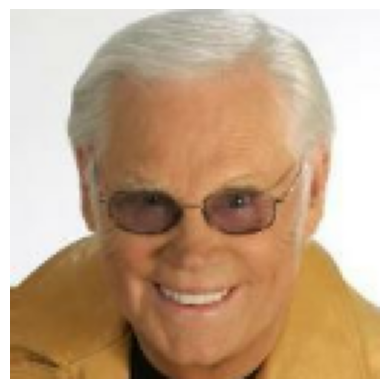

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGES_PATH, label_mode = None, color_mode = COLOR_MODE, batch_size = BATCH_SIZE, image_size = (IMAGE_RES, IMAGE_RES), crop_to_aspect_ratio = True, shuffle = True
)

dataset = dataset.map(lambda x: x / 255.0)

for i in dataset:
    plt.axis("off")
    plt.imshow((i.numpy() * 255).astype("int32")[0])
    break


# Step 5. Generator & Discriminator Definition

In [ ]:
def Discriminator(image_shape):
    
    model = Sequential()
    
    model.add(Conv2D(32, strides = 2, kernel_size = 4, input_shape= image_shape, padding = "same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(64, strides = 2, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, strides = 2, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(256, strides = 1, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, strides = 1, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model


def Generator(seed_size, channels):
    
    model = Sequential()
    model.add(Dense(4 * 4 * 256, input_dim = seed_size))
    model.add(Reshape((4,4,256)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, strides = 1, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(256, strides = 1, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, strides = 1, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
    model.add(BatchNormalization(momentum=0.99))
    model.add(LeakyReLU(alpha = 0.2))

    if RES_FACTOR > 1:
      model.add(UpSampling2D(size=(RES_FACTOR,RES_FACTOR)))
      model.add(Conv2D(128, strides = 1, kernel_size = 4, padding="same", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)))
      model.add(BatchNormalization(momentum=0.99))
      model.add(LeakyReLU(alpha = 0.2))
    
    
    model.add(Conv2D(channels, strides = 1, kernel_size = 5, padding="same", activation = "sigmoid"))
    
    return model

## Step 6. Save Images Method Definition

In [ ]:
def save_images(cnt,noise):
    image_array = np.full((
    PREVIEW_MARGIN + (PREVIEW_ROWS * (IMAGE_RES+PREVIEW_MARGIN)), 
    PREVIEW_MARGIN + (PREVIEW_COLS * (IMAGE_RES+PREVIEW_MARGIN)), IMAGE_CHANNELS), 
    255, dtype=np.uint8)
    
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5
    
    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (IMAGE_RES+16) + PREVIEW_MARGIN
            c = col * (IMAGE_RES+16) + PREVIEW_MARGIN
            image_array[r:r+IMAGE_RES,c:c+IMAGE_RES] \
                = generated_images[image_count] * 255
            image_count += 1
    
    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    filename = os.path.join(output_path,f"image_at_epoch_{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)
            

## Step 7. Testing the generator and Discriminator functions

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         1048832   
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 256)         0

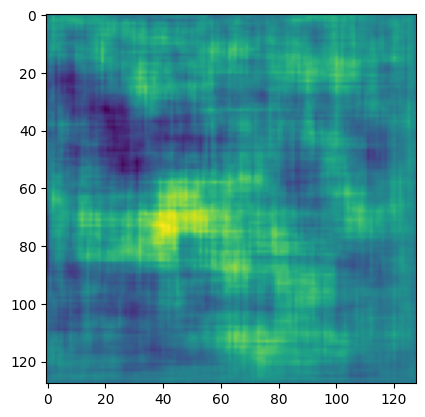

In [ ]:
generator = Generator(SEED_SIZE, IMAGE_CHANNELS)
generator.summary()
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (IMAGE_RES,IMAGE_RES,IMAGE_CHANNELS)

discriminator = Discriminator(image_shape)
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        1568      
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 zero_padding2d (ZeroPadding  (None, 33, 33, 64)       0         
 2D)                                                  

## Step 8. Defining the loss function (Cross-Entropy) and Optimizer(Adam)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5, clipvalue=1.0, decay=1e-8)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.5, clipvalue=1.0, decay=1e-8)

## Step 8.5 Adding Checkpoint System and a fixed seed




In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                          discriminator_optimizer=discriminator_optimizer,
                          generator=generator,
                          discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_PATH, max_to_keep=3)

In [ ]:
fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))

## Step 9. Generator and Discriminator Training Definition

In [ ]:
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    

        gradients_of_generator = gen_tape.gradient(\
            gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(\
            disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(
            gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(
            gradients_of_discriminator, 
            discriminator.trainable_variables))
    return gen_loss,disc_loss

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def train(dataset, epochs):
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        latest_epoch = int(manager.latest_checkpoint.split('-')[1])
        CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
        print("Latest checkpoint of epoch {} restored".format(CURRENT_EPOCH))
    else:
        print("Initializing from scratch.")
        CURRENT_EPOCH = 1
      
    start = time.time()

    for epoch in range(CURRENT_EPOCH, epochs+1):
        epoch_start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0]) 
            disc_loss_list.append(t[1])

        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        save_images(epoch,fixed_seed)
          
        if epoch % SAVE_EVERY_N_EPOCH == 0:
          manager.save()
          epoch_elapsed = time.time()-epoch_start
          print (f'Saved Epoch {epoch}, gen loss={g_loss},disc loss={d_loss},'\
               f' {hms_string(epoch_elapsed)}')
          
        if epoch == epochs:
           manager.save()
           epoch_elapsed = time.time()-epoch_start
           print (f'Saved Final Epoch {epoch}, gen loss={g_loss},disc loss={d_loss},'\
               f' {hms_string(epoch_elapsed)}')
        
        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch}, gen loss={g_loss},disc loss={d_loss},'\
               f' {hms_string(epoch_elapsed)}')

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

## Step 10. Start the training 

In [ ]:
train(dataset, EPOCH_NUM)

## Step 11. Save the Generator and Discriminator models after training

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))
discriminator.save(os.path.join(DATA_PATH,"face_discriminator.h5"))

## Step 12. Create a GIF file of all the generated images (optional)

In [5]:
%cd ..

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob("gdrive/MyDrive/GAN/src/output/image*.png")
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

/


<ipython-input-5-01e78373fd2f>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [6]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)